In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shreelakshmigp/cedardataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cedardataset


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import numpy as np
import matplotlib.pyplot as plt


In [3]:
import os
import shutil

# Original dataset path (read-only)
source_dir = "/kaggle/input/cedardataset/signatures"

# New dataset path (writable)
target_dir = "/mnt/data/cedar_dataset/signatures"
os.makedirs(target_dir, exist_ok=True)

# Subfolders to copy
for subfolder in ["full_forg", "full_org"]:
    src = os.path.join(source_dir, subfolder)
    dst = os.path.join(target_dir, subfolder)
    shutil.copytree(src, dst, dirs_exist_ok=True)

print("Dataset copied successfully!")



Dataset copied successfully!


In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
BASE_PATH = "/mnt/data/cedar_dataset/signatures"
FORGED_PATH = os.path.join(BASE_PATH, "full_forg")
GENUINE_PATH = os.path.join(BASE_PATH, "full_org")
DEST_PATH = "/mnt/data/cedar_processed"
TRAIN_DIR = os.path.join(DEST_PATH, "train")
TEST_DIR = os.path.join(DEST_PATH, "test")

# Create directory structure
for label in ["forged", "genuine"]:
    os.makedirs(os.path.join(TRAIN_DIR, label), exist_ok=True)
    os.makedirs(os.path.join(TEST_DIR, label), exist_ok=True)

# Function to split and copy images
def split_and_copy_images(source_folder, label, train_dest, test_dest, test_ratio=0.1):
    files = [f for f in os.listdir(source_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    train_files, test_files = train_test_split(files, test_size=test_ratio, random_state=42)
    for f in train_files:
        shutil.copy(os.path.join(source_folder, f), os.path.join(train_dest, label, f))
    for f in test_files:
        shutil.copy(os.path.join(source_folder, f), os.path.join(test_dest, label, f))

# Apply splitting
split_and_copy_images(FORGED_PATH, "forged", TRAIN_DIR, TEST_DIR)
split_and_copy_images(GENUINE_PATH, "genuine", TRAIN_DIR, TEST_DIR)

print(" Dataset split and copied successfully!")


 Dataset split and copied successfully!


In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
TRAIN_DIR = "/mnt/data/cedar_processed/train"
TEST_DIR = "/mnt/data/cedar_processed/test"

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32



train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1./255)


# Flow from directory
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False
)



Found 2376 images belonging to 2 classes.
Found 264 images belonging to 2 classes.


In [39]:
print("Class indices:", train_generator.class_indices)


Class indices: {'forged': 0, 'genuine': 1}


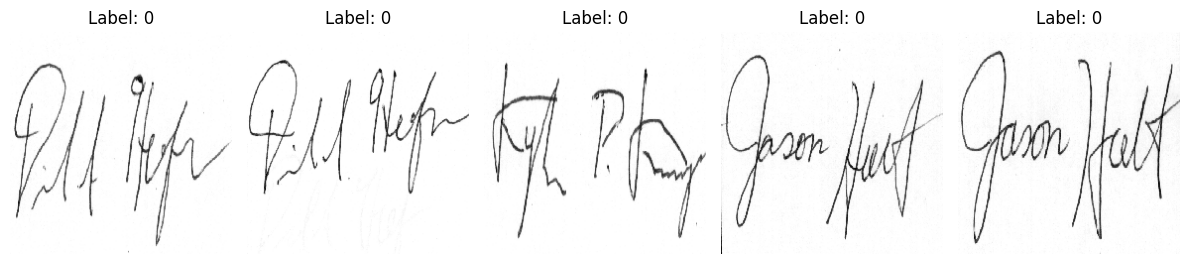

In [40]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
# Use test_generator instead of validation_data_data
images, labels = next(test_generator)

# Check if the images array is empty
if images.size == 0:
    print("Error: The images array is empty. Check your data path and ensure there are images in the training directory.")
else:
    # Proceed to display images if not empty
    plt.figure(figsize=(12, 4))
    for i in range(min(5, images.shape[0])):  # Limit to the number of images in the batch
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [42]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(512,(3,3),activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 222, 222, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 222, 222, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 109, 109, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 109, 109, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 54, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 52, 52, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 52, 52, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 26, 26, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 24, 24, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 24, 24, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │      37,749,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,303,425 (149.93 MB)

 Trainable params: 39,301,505 (149.92 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [44]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 426ms/step - accuracy: 0.9323 - loss: 4.6797 - val_accuracy: 0.6780 - val_loss: 7.9403 - learning_rate: 0.0010
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 267ms/step - accuracy: 0.9962 - loss: 0.2286 - val_accuracy: 0.5000 - val_loss: 86.9916 - learning_rate: 0.0010
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 290ms/step - accuracy: 0.9989 - loss: 0.0405 - val_accuracy: 0.5000 - val_loss: 348.7034 - learning_rate: 0.0010
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9976 - loss: 0.2185
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 275ms/step - accuracy: 0.9976 - loss: 0.2261 - val_accuracy: 0.5000 - val_loss: 409.6075 - learning_rate: 0.0010
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 278ms/step - accuracy: 0.9926 - loss: 0.9443 - val_accuracy: 0.5000 - val_loss: 257.6095 - learning_rate: 5.0000e-04
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 302ms/step - accuracy: 0.9986 -

In [12]:
print("Class indices:", train_generator.class_indices)
print("Train samples:", train_generator.samples)
print("Test samples:", test_generator.samples)

Class indices: {'forged': 0, 'genuine': 1}
Train samples: 2376
Test samples: 264


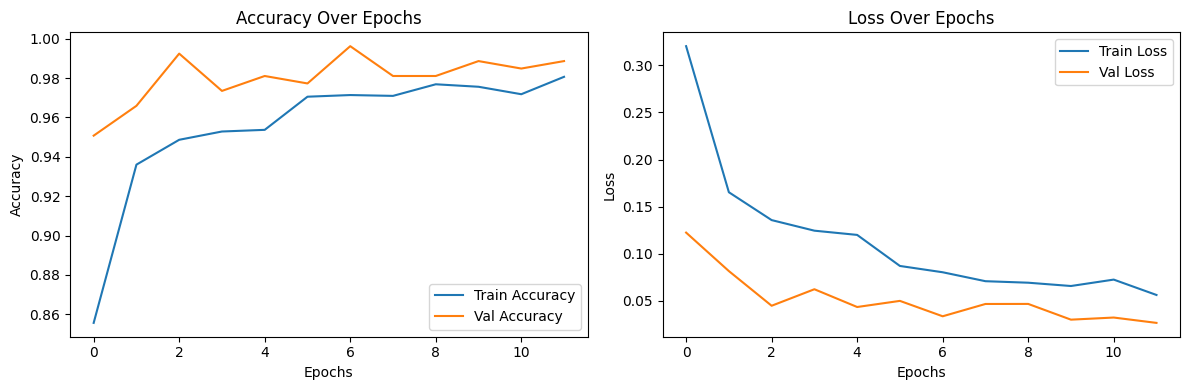

In [57]:
# Plot training accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Over Epochs")

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Over Epochs")

plt.tight_layout()
plt.show()


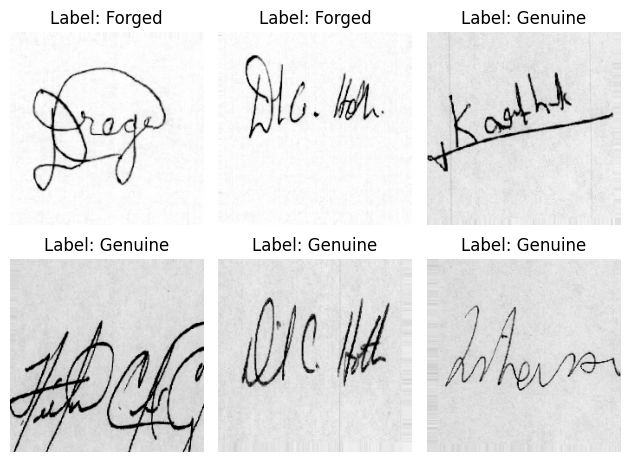

In [59]:
import matplotlib.pyplot as plt

images, labels = next(train_generator)

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title('Label: ' + ('Forged' if labels[i]==0 else 'Genuine'))
    plt.axis('off')

plt.tight_layout()
plt.show()


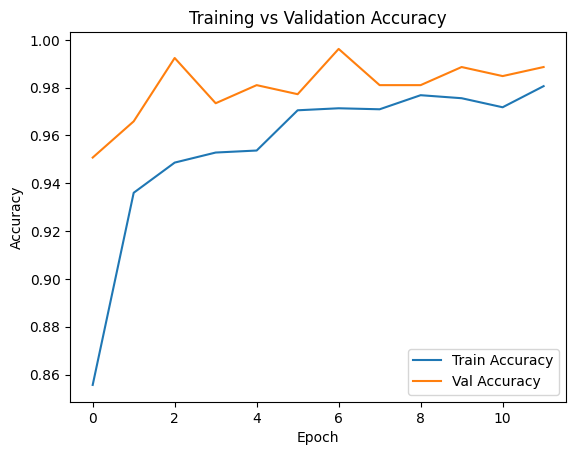

In [60]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

In [61]:
# Save your model in H5 format
model.save("signature_version_model.h5")


In [62]:
!pip install streamlit tensorflow opencv-python pillow

In [64]:
# app.py
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image
import cv2

# Load the model
model = tf.keras.models.load_model("signature_version_model.h5")

# Preprocessing function (adjust according to your training)
def preprocess_image(img):
    img = img.convert("L")  # grayscale
    img = img.resize((155, 220))  # Resize to match training input
    img = np.array(img) / 255.0   # Normalize
    img = img.reshape(1, 220, 155, 1)  # Add batch & channel dims
    return img

# UI
st.title("🖋️ Forged Signature Detection")
st.write("Upload a signature to check if it's **genuine** or **forged**.")

uploaded_file = st.file_uploader("Choose a signature image", type=["jpg", "png", "jpeg"])

if uploaded_file:
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Signature', use_column_width=True)

    if st.button("Predict"):
        processed = preprocess_image(image)
        prediction = model.predict(processed)

        # If binary classification with sigmoid output
        label = "Genuine" if prediction[0][0] > 0.5 else "Forged"
        confidence = prediction[0][0] if label == "Genuine" else 1 - prediction[0][0]

        st.markdown(f"### 🔍 Prediction: **{label}**")
        st.markdown(f"Confidence: `{confidence:.2f}`")



2025-04-06 02:02:01.122 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 02:02:01.123 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 02:02:01.125 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 02:02:01.126 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 02:02:01.127 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 02:02:01.128 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 02:02:01.130 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 02:02:01.131 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


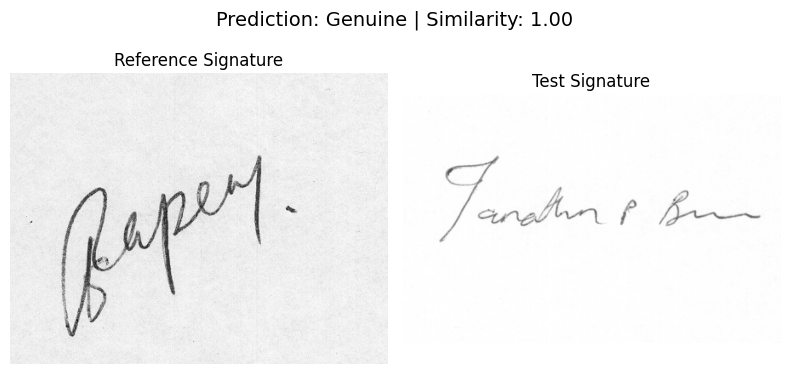

In [67]:
import os
import random
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# Load model
model = tf.keras.models.load_model("signature_version_model.h5")


# CEDAR path - Updated paths
genuine_dir = "/kaggle/input/cedardataset/signatures/full_org"  # Corrected path to genuine signatures
forged_dir = "/kaggle/input/cedardataset/signatures/full_forg"  # Corrected path to forged signatures

# Image preprocessor (match your training setup)
def preprocess(img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((224, 224))  # match model input
    img = np.array(img) / 255.0
    img = img.reshape(224, 224, 3)
    return img

# Pick one genuine image
genuine_imgs = os.listdir(genuine_dir)
genuine_path = os.path.join(genuine_dir, random.choice(genuine_imgs))

# Pick a random second image (can be genuine or forged)
is_forged = random.choice([True, False])
compare_dir = forged_dir if is_forged else genuine_dir
compare_imgs = os.listdir(compare_dir)
compare_path = os.path.join(compare_dir, random.choice(compare_imgs))

# Preprocess both
img1 = preprocess(genuine_path)
img2 = preprocess(compare_path)

# Prepare for prediction
img1 = np.expand_dims(img1, axis=0)
img2 = np.expand_dims(img2, axis=0)

# Predict similarity
# The model is designed for single image input, not two
# prediction = model.predict([img1, img2])[0][0] # This line is causing the error.

# Predict on each image separately
prediction1 = model.predict(img1)[0][0]
prediction2 = model.predict(img2)[0][0]

# Calculate a similarity score (e.g., absolute difference)
similarity = 1 - abs(prediction1 - prediction2)

# You might need to adjust the threshold for 'Genuine' vs 'Forged'
label = "Genuine" if similarity > 0.9 else "Forged" # Adjust threshold as needed


# Show result
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(Image.open(genuine_path), cmap='gray')
plt.title("Reference Signature")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(Image.open(compare_path), cmap='gray')
plt.title("Test Signature")
plt.axis("off")

plt.suptitle(f"Prediction: {label} | Similarity: {similarity:.2f}", fontsize=14) # Use similarity
plt.tight_layout()
plt.show()

Enter path to the first image: /content/WhatsApp Image 2025-04-06 at 3.12.13 AM.jpeg
Enter path to the second image: /content/WhatsApp Image 2025-04-06 at 3.12.13 AM.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


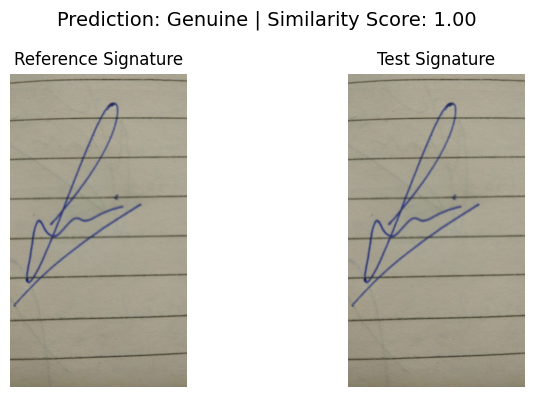

In [75]:
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import os

# === CONFIG ===
MODEL_PATH = "signature_version_model.h5"  # update if your model is elsewhere
IMG_SIZE = (224, 224)  # match to your model's input

# === LOAD MODEL ===
model = tf.keras.models.load_model(MODEL_PATH)

# === PREPROCESS FUNCTION ===
def preprocess(img_path):
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image not found: {img_path}")

    img = Image.open(img_path).convert("RGB")
    img = img.resize(IMG_SIZE)
    img = np.array(img) / 255.0
    img = img.reshape(IMG_SIZE[0], IMG_SIZE[1], 3)  # Reshape to (224, 224, 3)
    return img

# === GET IMAGE PATHS ===
img1_path = input("Enter path to the first image: ").strip()
img2_path = input("Enter path to the second image: ").strip()

# === PREPROCESS IMAGES ===
try:
    img1 = preprocess(img1_path)
    img2 = preprocess(img2_path)
except Exception as e:
    print(f"Error loading images: {e}")
    exit()

# === PREPARE FOR PREDICTION ===
img1 = np.expand_dims(img1, axis=0)
img2 = np.expand_dims(img2, axis=0)

# === PREDICT SIMILARITY ===
# Predict on each image separately
prediction1 = model.predict(img1)[0][0]
prediction2 = model.predict(img2)[0][0]

# Calculate similarity (e.g., absolute difference of predictions)
similarity = 1 - abs(prediction1 - prediction2)
label = "Genuine" if similarity > 0.9 else "Forged"  # Adjust threshold as needed

# === DISPLAY RESULTS ===
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(Image.open(img1_path), cmap='gray')
plt.title("Reference Signature")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(Image.open(img2_path), cmap='gray')
plt.title("Test Signature")
plt.axis("off")

plt.suptitle(f"Prediction: {label} | Similarity Score: {similarity:.2f}", fontsize=14)
plt.tight_layout()
plt.show()

In [51]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input



In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)  # MobileNetV2 default input size
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.1,
    rotation_range=5,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05
)


train_data_dir = '/kaggle/input/cedardataset/signatures' # your actual data path


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    color_mode='rgb',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    color_mode='rgb',
    subset='validation'
)

Found 2376 images belonging to 2 classes.
Found 264 images belonging to 2 classes.


In [54]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze pretrained layers

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [55]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 63s 696ms/step - accuracy: 0.7713 - loss: 0.4683 - val_accuracy: 0.9508 - val_loss: 0.1225 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 532ms/step - accuracy: 0.9223 - loss: 0.1868 - val_accuracy: 0.9659 - val_loss: 0.0817 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 39s 525ms/step - accuracy: 0.9445 - loss: 0.1495 - val_accuracy: 0.9924 - val_loss: 0.0450 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 536ms/step - accuracy: 0.9577 - loss: 0.1109 - val_accuracy: 0.9735 - val_loss: 0.0625 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 532ms/step - accuracy: 0.9563 - loss: 0.1176 - val_accuracy: 0.9811 - val_loss: 0.0436 - learning_rate: 0.0010
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 527ms/step - accuracy: 0.9745 - loss: 0.0856 - val_accuracy: 0.9773 - val_loss: 0.0501 - learning_rate: 5.0000e-04
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 39s 524ms/step - accuracy: 0.9789 - loss

In [56]:
loss, acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {acc*100:.2f}%")


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 410ms/step - accuracy: 0.9894 - loss: 0.0326
Validation Accuracy: 98.86%


In [72]:
from google.colab import files
files.download('signature_version_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [73]:
from google.colab import drive
drive.mount('/content/drive')

# save directly to drive
model.save('/content/drive/MyDrive/signature_version_model.h5')

Mounted at /content/drive
